<a href="https://colab.research.google.com/github/AnnaZhuravleva/compling/blob/master/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6

[3 points] Delelop language model, which generates texts from wikipedia.   
Use WikiText-2 dataset, also available in `torchtext.datasets`.  
Use `sentencepiece` or `tokenizers` library for text tokenization. Pay attention to vocab size, probably subword tokens are better.    
Your model should be autogressive RNN.  
[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.  
[1 point] Try to use together (`sentencepiece` or `tokenizers`), `torchtext.datasets`, and `torchtext.data.BPTTIterator`  

<img src="https://github.com/thedenaas/hse_seminars/blob/master/2019/seminar_9/images/lm.jpg?raw=1" style="height:300px">

Text generation should be terminated when either max length is reached or terminal symbol is generated.  
Explore several inference techniques:
1. [1 point] Argmax
1. [1 point] Beamsearch
1. [1 point] Sampling from probabilty distribution with temperature
1. [1 point] Nucleus sampling
1. [1 point] Top-k sampling


For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

Readings:
https://arxiv.org/abs/1904.09751

In [54]:
import torchtext
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
from nltk import sent_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import gensim
import spacy
from tqdm import tqdm_notebook

from sklearn import metrics
import re
import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V
from torchtext.data import Field, LabelField, BucketIterator, ReversibleField
from torchtext.datasets import WikiText2


SEED = 42
np.random.seed(SEED)
np.random.seed(42)

from torchtext import data
import spacy


spacy_en = spacy.load('en')
spacy_en.remove_pipe('tagger')
spacy_en.remove_pipe('ner')

!pip install tokenizers
from tokenizers import SentencePieceBPETokenizer

def tokenizer(text): 
    return [tok.lemma_ for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [35]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/Colab Notebooks/compling'
sys.path.append(project_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Нужно натренировать subwordtokenizer**

- Почистим текст от лишних пробелов и символов unk
- Добавим терминальный символ eos
- Натренируем токенизатор на тренировочном датасете

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/compling/wikitext-2/wikitext-2/wiki.train.tokens') as train_file:
    train_tokens = train_file.read()
with open('/content/drive/My Drive/Colab Notebooks/compling/wikitext-2/wikitext-2/raw_train', 'w', encoding='utf-8') as f:
    f.write(preproc_text(train_tokens))

spbpetokenizer = SentencePieceBPETokenizer()
spbpetokenizer.add_special_tokens(["<eos>", "<unk>"])
spbpetokenizer.train('/content/drive/My Drive/Colab Notebooks/compling/wikitext-2/wikitext-2/raw_train', vocab_size=3000)


def preproc_text(train_tokens):
    train_tokens = train_tokens.replace('<unk>', '')
    train_tokens = re.sub('(\s)+', ' ', train_tokens)
    train_tokens = re.sub(r'( )([.!?;:,\)])', r'\2', train_tokens)
    train_tokens = re.sub(r'(\")(\s*)(\S+)(\s*)(\")', r'"\3"', train_tokens)
    train_tokens = list(sent_tokenize(train_tokens))
    train_tokens = [i[:-1]+' <eos>' for i in train_tokens]
    return ' '.join(train_tokens)

def bpe_tokenizer(text):
    return spbpetokenizer.encode(preproc_text(text)).tokens

In [146]:
len(preproc_text(train_tokens)), len(train_tokens)

(10558140, 10780437)

In [147]:
#TEXT = Field(include_lengths=False, batch_first=True, 
#             tokenize=tokenizer,
#             eos_token='<eos>',
#             lower=True,
#             stop_words=nltk.corpus.stopwords.words('english')
#            )

TEXT = Field(include_lengths=False, batch_first=True, lower=True, tokenize=bpe_tokenizer)

train, valid, test = WikiText2.splits(TEXT)
TEXT.build_vocab(train, min_freq=5)
len(TEXT.vocab.itos)

160

In [151]:
for i in range(len(TEXT.vocab.itos)):
  print(i, TEXT.vocab.itos[i])

0 <unk>
1 <pad>
2 ▁
3 t
4 e
5 s
6 o
7 i
8 l
9 c
10 a
11 u
12 h
13 r
14 ▁the
15 ▁s
16 <eos>
17 m
18 ▁a
19 er
20 d
21 y
22 g
23 ▁w
24 ,
25 n
26 ed
27 p
28 v
29 on
30 es
31 ▁p
32 b
33 he
34 or
35 ▁of
36 ▁b
37 ▁in
38 ▁t
39 ar
40 ▁and
41 ing
42 en
43 it
44 at
45 ▁f
46 al
47 w
48 in
49 ▁to
50 an
51 f
52 ▁d
53 k
54 ▁m
55 re
56 le
57 hi
58 is
59 1
60 ▁n
61 0
62 ur
63 nd
64 ▁re
65 st
66 ▁=
67 ▁"
68 ▁r
69 el
70 ac
71 ▁o
72 me
73 ec
74 2
75 ▁for
76 ti
77 ▁@-@
78 os
79 ▁as
80 j
81 ▁h
82 ta
83 ion
84 ▁is
85 ia
86 co
87 un
88 (
89 tion
90 @
91 s,
92 )
93 ▁it
94 ation
95 ev
96 ay
97 op
98 .
99 ment
100 ▁com
101 cal
102 ga
103 de
104 ak
105 ame
106 3
107 eri
108 ▁3
109 ary
110 ▁ch
111 les
112 lay
113 ide
114 red
115 ▁un
116 :
117 lit
118 "
119 ▁201
120 ron
121 nt
122 ▁ga
123 ▁game
124 pan
125 ega
126 ▁series
127 com
128 ▁develop
129 ja
130 ria
131 ▁ii
132 ky
133 ▁unit
134 01
135 tical
136 ▁japan
137 ▁dev
138 -
139 ▁val
140 ▁iii
141 ▁seri
142 elop
143 cles
144 201
145 ▁tac
146 ii
147 icles
148 ▁chron
1

In [0]:
device = tt.device('cuda') if tt.cuda.is_available() else tt.device('cpu')
train_iter, valid_iter, test_iter = data.BPTTIterator.splits((train, valid, test),
    batch_size=64,
    bptt_len=40, 
    device=device,
    repeat=False)

In [153]:
b = next(iter(train_iter))
vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

**Develop a model**
--

In [0]:
 # as in https://github.com/thedenaas/hse_seminars/blob/master/2019/seminar_9/rnn.ipynb


class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)     
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )      
        self.fc = nn.Linear(hidden_size * 2, vocab_size)       
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        x = batch.text.T if hasattr(batch, 'text') else batch
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x.transpose(1,2)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()
    history = []
    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc=f'epoch {curr_epoch + 1}', leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()
        history.append(loss.item())
        curr_loss = loss.data.cpu().detach().item()
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss
        iterator.set_postfix(loss='%.5f' % running_loss)
    return running_loss, history

def _test_epoch(model, iterator, criterion):
    history = []
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with tt.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            history.append(loss.item())
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches, history


def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()
    train_history_all = []
    test_history_all = []

    for epoch in range(n_epochs):
        print(f'Epoch: {epoch}')
        train_loss, train_history = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss, test_history = _test_epoch(model, valid_iterator, criterion)
        train_history_all += train_history
        test_history_all += test_history
        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)
        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            es_epochs = es_epochs + 1 if valid_loss > prev_loss else 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return train_history_all, test_history_all

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=1)

In [157]:
X1, X2 = nn_train(model, train_iter, valid_iter, criterion, optimizer, scheduler=scheduler, n_epochs=2, early_stopping=2)

Epoch: 0


validation loss 0.07840
Epoch: 1


validation loss 0.07293


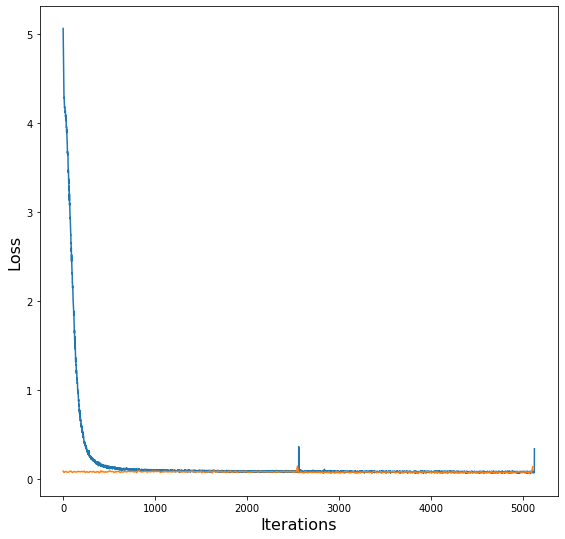

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)

plt.plot(range(len(X1)), X1, np.array(range(len(X2)))*10, X2)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

**Predict sentences**
--

In [0]:
def build_sent(model, function, start, end='<eos>', max_len=55):
    eos = TEXT.vocab.stoi[end]
    with tt.no_grad():
        seq = start
        res = ''
        while seq[-1] != eos and len(res.split('▁')) <= 10:
          pred = model(tt.tensor([seq]))[:,:,-1]
          seq.append(function(pred))
          res = ''.join([TEXT.vocab.itos[v] for v in seq])
    return re.sub('▁', ' ', res)


In [196]:
def argmax_case(prob):
    return tt.argmax(prob).item()
for i in range(4, 20):
    a = build_sent(model, argmax_case, start=[i])
    print(a)
print('---')
for i in range(len(TEXT.vocab.itos)):
    a = build_sent(model, argmax_case, start=[i])
    if len(a.split(' ')) >= 5:
        print(a)

e <eos>
s <eos>
oth <eos>
illy <eos>
lice <eos>
ce <eos>
ast contromage <eos>
ulter <eos>
hourn <eos>
rom <eos>
 the contromage <eos>
 store <eos>

mant <eos>
 an 10 <eos>
ers <eos>
---
 of the contromage <eos>
 that had contromage <eos>
 = =  <eos>
 as the contromage <eos>
 is an contromage <eos>


The quality is bad

I will improve as soon as possible:
- other dictionary size
- More epochs
- Other inference techniques


